In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform
import fiona
from matplotlib import pyplot, transforms
import numpy as np
# from fiona.crs import from_epsg

def make_point(row):
    ''' making the point for df
    '''
    return Point(
        transform(
            Proj(init='EPSG:4326'), Proj(base.crs), row['Longititude'], row['Latitude']))

def transform_point(x1,y1):
    inProj = Proj(init='epsg:32054', preserve_units=True)
    outProj = Proj(init='epsg:4326')
    x2,y2 = transform(inProj,outProj,x1,y1)
    return x2,y2

In [2]:
# base = gpd.read_file('AB/lcsd000a17a_e.shp')
base = gpd.read_file('AB Shapes/lfed000a16a_e.shp')

# select only Alberta
dt = base.loc[(base['PRNAME'] == 'Alberta') & 
    (~base['FEDFNAME'].isin(['Fort McMurray--Cold Lake','Grande Prairie--Mackenzie','Peace River--Westlock', 'Yellowhead']))]

dt.head(4)

,FEDUID,FEDNAME,FEDENAME,FEDFNAME,PRUID,PRNAME,geometry
217,48008,Calgary Midnapore,Calgary Midnapore,Calgary Midnapore,48,Alberta,"POLYGON ((4685555.719999999 1914799.671429999,..."
218,48009,Calgary Nose Hill,Calgary Nose Hill,Calgary Nose Hill,48,Alberta,"POLYGON ((4690370.314284999 1935215.285714999,..."
219,48010,Calgary Rocky Ridge,Calgary Rocky Ridge,Calgary Rocky Ridge,48,Alberta,"POLYGON ((4684997.491429999 1940795.817145001,..."
220,48011,Calgary Shepard,Calgary Shepard,Calgary Shepard,48,Alberta,"POLYGON ((4690529.242855001 1919144.122855, 46..."


In [3]:
# read  windfarm points
windfarms = pd.read_excel('NRGstreamData/WindFarms.xlsx').sort_values(by='Asset ID')
n_windfarms = len(windfarms.index) #n_windfarms = windfarms.shape[0]
windfarms.reset_index(inplace=True)
windfarms.drop(['index'],axis=1,inplace=True)

Lons = windfarms['Longititude'].tolist()
Lats = windfarms['Latitude'].tolist()
Caps = windfarms['Capacity'].tolist()
points = windfarms.apply(make_point,axis=1)
windfarms_geoDF = gpd.GeoDataFrame(windfarms, geometry=points)
windfarms_geoDF.head(4)

,Farm Name,Asset ID,Longititude,Latitude,Capacity From AESO,Capacity,Max Production,StreamID,StreamID H Avg,Original_bus_num,max avg hourly production,geometry
0,McBride Lake,AKE1,-113.454389,49.546583,73,73,72.08,2735,2736,2901,AKE1 72.00,POINT (4670755.773367089 1751743.069928965)
1,Ardenville Wind,ARD1,-113.450000,49.549972,68,68,68.17,93924,93928,4735,ARD1 68.17,POINT (4671179.85599042 1751992.248774622)
2,Blackspring Ridge,BSR1,-113.026603,50.601512,300,300,296.00,135613,135615,61736,BSR1 296.00,POINT (4738087.251223223 1852018.009680165)
3,Blue Trail Wind,BTR1,-113.424200,49.651600,66,66,65.83,83936,83935,67328,BTR1 65.83,POINT (4676686.196831582 1762008.334663689)


## Rotate two geopandas.geodataframe.GeoDataFrame

In [4]:
dt_new = dt.rotate(18, origin = (0,0), use_radians=False)

windfarms_new=windfarms.copy()
points_new = windfarms_geoDF.copy()
points_new = points_new.rotate(18, origin = (0,0), use_radians=False)
windfarms_geoDF_new = gpd.GeoDataFrame(windfarms.copy(), geometry=points_new)

# points2 = windfarms_geoDF.rotate(18, origin = (0,0), use_radians=False)
# windfarms_geoDF2 = gpd.GeoDataFrame(windfarms, geometry=points2)

# transform Longititude and Latitude
a = [transform_point(windfarms['Longititude'].iloc[i], windfarms['Latitude'].iloc[i]) for i in range(20)]
Long  = [a[i][0] for i in range(20)]
Lat = [a[i][1] for i in range(20)]
windfarms_geoDF_new['Longititude'] = Long
windfarms_geoDF_new['Latitude'] = Lat
windfarms_geoDF_new.head(4)

,Farm Name,Asset ID,Longititude,Latitude,Capacity From AESO,Capacity,Max Production,StreamID,StreamID H Avg,Original_bus_num,max avg hourly production,geometry
0,McBride Lake,AKE1,-97.337700,41.758573,73,73,72.08,2735,2736,2901,AKE1 72.00,POINT (3900834.335897387 3109349.57207615)
1,Ardenville Wind,ARD1,-97.337700,41.758573,68,68,68.17,93924,93928,4735,ARD1 68.17,POINT (3901160.661941807 3109717.603978663)
2,Blackspring Ridge,BSR1,-97.337698,41.758576,300,300,296.00,135613,135615,61736,BSR1 296.00,POINT (3933883.716171202 3225523.277861558)
3,Blue Trail Wind,BTR1,-97.337699,41.758574,66,66,65.83,83936,83935,67328,BTR1 65.83,POINT (3903302.362522895 3120945.020627972)


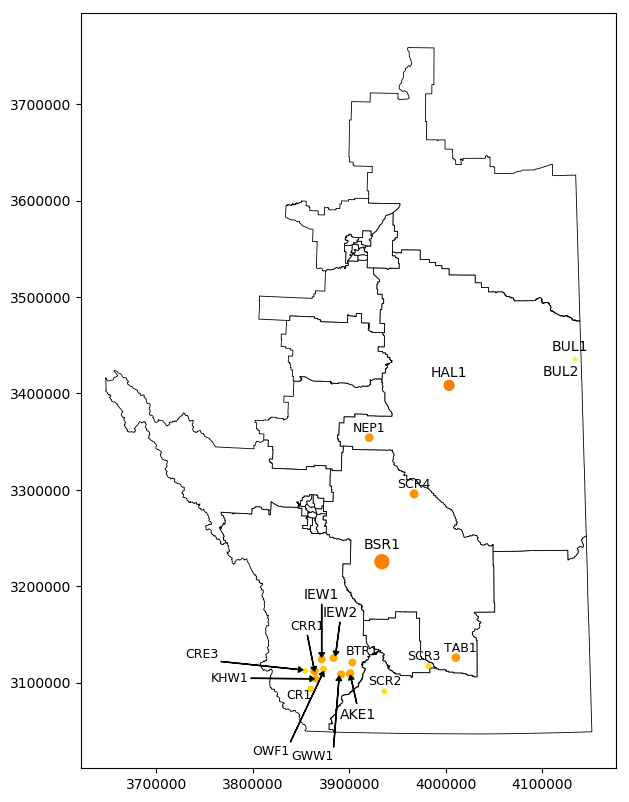

In [5]:
from position_of_windfarms_map import *

fig, this_ax = plt.subplots(figsize=(8,10),dpi=100)
ind=list(range(0,20))
this_ax.set_aspect('equal')

dt_new.plot(ax=this_ax, color='white', linewidth=0.6, edgecolor='black') #transform= rot + base

this_x = add_names(windfarms_geoDF_new,this_ax,windfarms,ind)

cmap = matplotlib.cm.get_cmap('Wistia'); colors = [cmap(ind) for ind in windfarms['Capacity']/100]
windfarms_geoDF_new.plot(ax=this_ax, marker='o', c= colors, markersize=windfarms['Capacity']/3)

# plt.axis('off')
# plt.savefig('windfarms_on_map.png', format='png',papertype='letter', dpi = 300, bbox_inches='tight')
plt.show();

# Plot clustered 

In [6]:
import matplotlib.patches as patches

clusters = np.array([1, 1, 2, 1, 4, 4, 0, 0, 0, 1, 3, 0, 0, 0, 3, 0, 1, 2, 3, 2]) # 5 cluasters
# clusters = np.array([4, 4, 2, 4, 3, 3, 1, 5, 1, 4, 0, 1, 1, 1, 0, 1, 4, 2, 0, 2]) # 6 clusters
clusters = np.array([2, 2, 3, 2, 5, 5, 0, 4, 0, 2, 1, 0, 0, 0, 1, 0, 2, 3, 6, 3]) # 7 clusters

clusters = np.array([4, 4, 3, 4, 1, 1, 0, 0, 0, 4, 2, 0, 0, 0, 2, 0, 4, 3, 2, 3])
clusters = np.array([3, 3, 5, 3, 2, 2, 0, 1, 0, 3, 4, 0, 0, 0, 4, 0, 3, 5, 4, 5])
# clusters = np.array([5, 5, 4, 5, 0, 0, 1, 6, 1, 5, 3, 1, 1, 1, 3, 1, 5, 2, 3, 2])
clusters = np.array([1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 0])

colors = ['darkorange','gold', 'firebrick', 'darkblue', 'darkgreen', 'chocolate']
colors = ['darkorange','gold', 'firebrick', 'darkblue', 'darkgreen', 'chocolate','grey','blue']
Legends = ['Cluster 1', 'Cluster 2', 'Cluster 3' ,'Cluster 4', 'Cluster 5','Cluster 6', 'Cluster 7']

In [7]:
#  to use rotated one
windfarms_geoDF = windfarms_geoDF_new
dt = dt_new

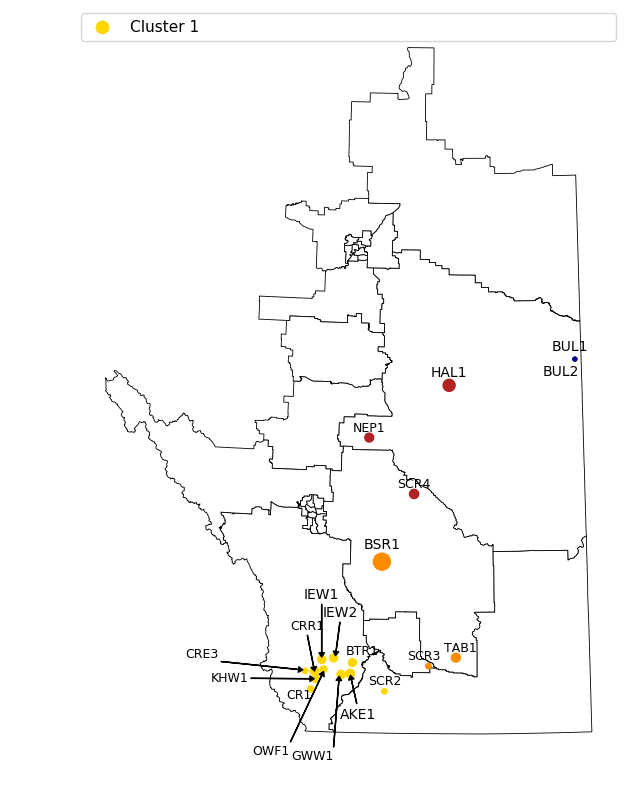

In [8]:
fig, this_ax = plt.subplots(figsize=(8,10),dpi=100)
this_ax.set_aspect('equal')
ind=list(range(0,20))

dt_new.plot(ax=this_ax, color='white', linewidth=0.6, edgecolor='black') 

add_names(windfarms_geoDF_new,this_ax,windfarms,ind)

colors2 = [colors[i] for i in clusters]
windfarms_geoDF_new.plot(ax=this_ax, marker='o', c= colors2, markersize=windfarms['Capacity']/2)

# p = [0,1,2,3,4]
# add_cluster_areas2(this_ax, windfarms_geoDF, clusters, p, colors)

plt.legend(Legends, bbox_to_anchor=(0., 1, 1.,0), loc=0,ncol=3, mode="expand", borderaxespad=0.,fontsize=11)

plt.axis('off')
# plt.savefig('windfarms_5clusters_with_cluster_areas.png', format='png',papertype='letter', dpi=300, bbox_inches='tight')
plt.show();

## Plot 10 pairs of clusters

In [ ]:
n_clusters = 5
from itertools import combinations
combs = list(combinations(range(n_clusters),2))
ind = 0
for i in range(len(combs)): #n_plots_figure * fig_n , min(n_plots_figure*(fig_n + 1), total_plots)\n",
    ind_0 = combs[i][0]
    ind_1 = combs[i][1]

combs = [(0,1,2,3,4)] #to plot all clusters once

In [ ]:

for j in range(len(combs)): #n_plots_figure * fig_n , min(n_plots_figure*(fig_n + 1), total_plots)\n",
    fig, this_ax = plt.subplots(figsize=(8,10),dpi=80)
    this_ax.set_aspect('equal')
    save_fig_name = 'windfarms_{}clusters'.format(n_clusters)

    dt.plot(ax=this_ax, color='white', linewidth=0.7, edgecolor='black') #transform= rot + base


    leg = []
    for t in range(len(combs[j])):
        p = combs[j][t]
        ind = np.where(clusters==p)[0]

        add_cluster_areas2(this_ax, windfarms_geoDF, clusters, [p], colors)

        a = windfarms_geoDF.iloc[ind,:]
        a.plot(ax=this_ax, marker='o', c= colors[p], markersize=(windfarms['Capacity']), label = 'ex',legend=True)

        leg.append(Legends[p]) 
        
        save_fig_name = save_fig_name + '_{}'.format(p)
    print(save_fig_name)

    plt.legend(leg, bbox_to_anchor=(0., 1, 1.,0), loc=0,ncol=3, mode="expand", borderaxespad=0.,fontsize=11)
    plt.axis('off')

#     plt.savefig(save_fig_name + '_with_cluster_area.png', format='png',papertype='letter', dpi = 300, bbox_inches='tight')
#     plt.close()

# Some codes for better understaning of GeoPandas 

In [ ]:
dt.iloc[5]['geometry']

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [ ]:
cities.plot(marker='*', color='green', markersize=5);
cities.crs
cities = cities.to_crs(world.crs)

In [ ]:
f, my_ax = plt.subplots(1, figsize=(11, 6))
ax = world.plot(ax=my_ax)
plt.show()

In [ ]:
from shapely.geometry import Point, LineString
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
